In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
import random

In [48]:
class Image:
    def __init__(self, matrix):
        self._m = matrix
        self._n = matrix.shape[0]
        self._blocks = self.get_blocks(matrix)

    def get_blocks(self, matrix):
        blocks = []
        for i in range(self.n):
            for j in range(self.n):
                if not matrix[i, j]:
                    blocks.append((i, j))
        return blocks

    def update_block(self, block, destination):
        self._m[block[0], block[1]] = True
        self._m[destination[0], destination[1]] = False

        self._blocks.remove(block)
        self._blocks.append(destination)

    def copy(self):
        new_matrix = self._m.copy()
        return Image(new_matrix)

    @property
    def m(self):
        return self._m

    @property
    def n(self):
        return self._n

    @property
    def blocks(self):
        return self._blocks


def get_random_image(n, density):
    image_matrix = np.random.randint(1, 100, size=(n, n))
    image_matrix = (image_matrix > 100*density)

    image = Image(image_matrix)

    return image


def dist(a, b):
    return abs(b[0] - a[0]) + abs(b[1] - a[1])


def is_neighbor(a, b, neighborhood_type):
    if neighborhood_type == 4:
        return dist(a, b) == 1
    elif neighborhood_type == 8:
        return abs(b[0] - a[0]) <= 1 and abs(b[1] - a[1]) <= 1
    elif neighborhood_type == 24:
        return abs(b[0] - a[0]) <= 2 and abs(b[1] - a[1]) <= 2
    else:
        return False


def get_energy(image, neighborhood_type):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy += 20
                elif is_neighbor(block1, block2, 8):
                    energy += 10
                elif is_neighbor(block1, block2, 24):
                    energy += 5

    return energy


def anneal(image, t_max, multiplier, iterations, neighborhood_type):
    frames = [image.m]

    optimal_image = image.copy()

    energy = get_energy(image, neighborhood_type)
    energies = [(0, energy)]

    it = 1
    t = t_max
    while it < iterations:
        while True:
            blocks = optimal_image.blocks.copy()
            block_to_move = random.choice(blocks)
            blocks.remove(block_to_move)

            moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            destination = block_to_move
            
            while moves:
                move = random.choice(moves)
                destination = (block_to_move[0] + move[0], block_to_move[1] + move[1])
                
                if destination[0] < 0 or destination[0] >= image.n or destination[1] < 0 or destination[1] >= image.n \
                        or not optimal_image.m[destination[0], destination[1]]:
                    moves.remove(move)
                    destination = block_to_move
                else:
                    break

            if destination != block_to_move:
                new_image = optimal_image.copy()
                new_image.update_block(block_to_move, destination)

                new_energy = get_energy(new_image, neighborhood_type)

                if new_energy > energy or math.e ** ((new_energy - energy) / t) > random.random():
                    optimal_image = new_image
                    energy = new_energy
                    frames.append(new_image.m)
                    energies.append((it, new_energy))

                break

        it += 1
        t *= multiplier

    frames.append(optimal_image.m)
    energies.append((it, energy))

    return optimal_image, frames, energies

<IPython.core.display.Javascript object>


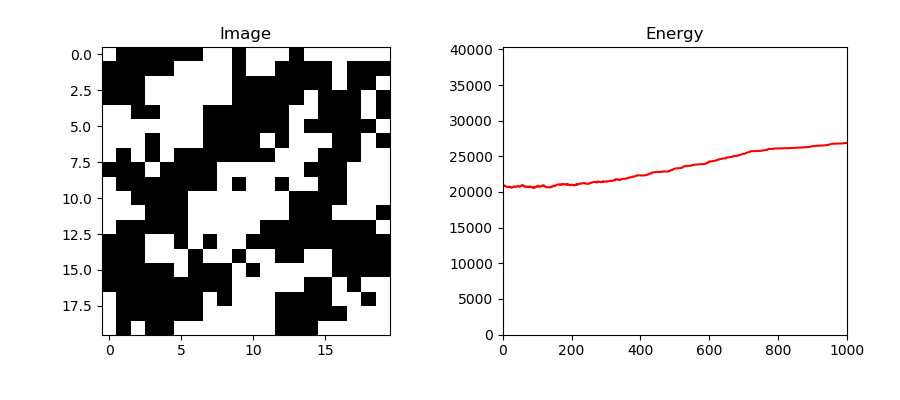

In [49]:
size = 20
density = 0.5

t_max = 1000
multiplier = 0.99
iterations = 1000
neighborhood_type = 24

%matplotlib nbagg

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.tight_layout(pad=3.0)

rand_image = get_random_image(size, density)
optimal_image, frames, costs = anneal(rand_image, t_max, multiplier, iterations, neighborhood_type)

image = ax[0].imshow(rand_image.m, cmap=plt.cm.gray)

ax[0].set_title("Image")

cost_line, = ax[1].plot([], [], 'r-')
ax[1].set_xlim(0, iterations)
ax[1].set_ylim(0, costs[len(costs)-1][1]*1.5)
# ax[1].set_ylim(0, 1000)
ax[1].set_title("Energy")
xcost = []
ycost = []

def update_path(i):
    frame = frames[int(i)]
    
    xcost.append(costs[int(i)][0])
    ycost.append(costs[int(i)][1])
    
    image.set_data(frame)
    cost_line.set_data(xcost, ycost)
    
    return image, cost_line

def update_cost(cost):
    xcost.append(cost[0])
    ycost.append(cost[1])
    
    cost_line.set_data(xcost, ycost)
    return cost_line, 


ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()